
<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
<img border="0" src="http://www.auchylesmines.fr/wp-content/uploads/2015/03/Logo-securite-routiere-651x263.jpg" width="60%"> </td>
  </tr>
</table> 
</div>

<center><h1>France accident challenge</h1></center>
<br/>
<center>Nayel Bettache (ENSAE), Axel Marchand (ENSAE), Solène Cochennec (HEC-ENSAE), Rodrigue Rillardon (ENSAE)</center>

Predicting accidents using Open Data Gouv Data: [Open Data Gouv](https://www.data.gouv.fr/fr/)

# <center> Table of Contents </center>

0. [Introduction](#intro)
1. [Aim](#aim)
1. [Data](#data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)
6. [Record linkage](#Record-linkage)
7. [Submission structure](#Submission-structure)
8. [Local testing](#Local-testing-(before-submission))
9. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))
10. [More information](#More-information)

<a id='intro'></a>
#  Introduction 

The objective of this challenge is to work with 'massive' and 'raw' data. We have a really high number of datasets, with most of the data either useless or at first not explained or use. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

We have at our disposal about 14 years of data about the road accidents in France from 2004 to 2018. We will only use 3 years to avoid using a dataset too huge. 

There are three accidents datasets in this challenge, and a trafic dataset which represents the recordings of 80 differents censors during describing the years 2018, 2017, 2016. 

* `caracteristiques_{YEAR}.csv` - basic data about the accidents, including the place of the accidents.
* `lieux_{YEAR}.csv` - data about the location of the accidents.
* `usagers_{YEAR}.csv` - data about the people involved in the accidents.
* `vehicules_{YEAR}.csv` - data about the vehicles involved.
* `sensors_data.csv` - data about the trafic sensors
* `meteo_jour.csv` - data about the weather daily in Paris 

We will first describe the steps leading to the creation of a train dataset named `paris_accident.csv` and we will then provide some early prediction.

<a id='aim'></a>

# Aim

The predictive aim of this challenge is to use the different datasets to predict the number of accidents for each neighborhood in Paris in an hour. It is advised that you use all datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `paris_accident.csv` dataset is also allowed.

<a id='data'></a>

# Data

## Trafic and accident data

This dataset was built from an extract of the [Open Data Gouv](https://www.data.gouv.fr/fr/datasets/base-de-donnees-accidents-corporels-de-la-circulation/) movement, a french dataset recording the road accidents for the last 14 years, and an [Open Data Paris](https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/information/) dataset, recording all the trafic data points from about 4000 locations. We have kept only a closed amount of data points to avoid the data being too heavy, but you are free to improve and to expand the size of the dataset.

Each row represent an hour of a day and a neighborhood of Paris:
* `Num_Qu` - the neighborhood where the data point was taken
* `Date` - the date given every hour
* `iu_ac` - the id of the sensor
* `q` - the number of cars during this hour
* `k` - a trafic score as explained [here](https://opendata.paris.fr/api/datasets/1.0/comptages-routiers-permanents/attachments/notice_donnes_trafic_capteurs_permanents_version_20190607_pdf/)
* `etat_trafic` - another trafic score
* `etat_barre` - another trafic score



## Weather data

This dataset was built scraping the public data of Meteo France. Each row represent the weather of one day in Paris.

* `jour` - the date of the day of the recording
* `temp_high` - the highest temperature of the day
* `temp_avg` - the average temperature of the day
* `temp_low` - the lowest temperature of the day
* `dew_point_high` - the highest dew point
* `dew_point_avg` - the average dew point
* `dew_point_low` - the lowest dew point
* `humidity_high` - the highest humidity
* `humidity_avg` - the average humidity
* `humidity_low` - the lowest humidity
* `speed_high` - the highest speed of the wind
* `speed_avg` - the average speed of the wind 
* `speed_low` - the lowest speed of the wind
* `pressure_high` - the highest pressure
* `pressure_low` - the lowest pressure
* `precipitation_acc` - an indice of the precipitation

## Training and test

The dataset used is split in two subsets:

* training
* test

# Score Metric

Our main objective is to predict car accidents. We model this problem by a classification problem with two labels: accident or no accident. 
We can also model the problem as a regression problem by trying to predict the number of accident on a defined area and on a defined amount of time.

Thus, we want to construct a loss function that penalize more the big relative margins between predictions and true values. Indeed, predicting 5 accidents when the true number is 5 cannot have the same impact as predicting 50 when the true number is 45. We also want to penalize harder the underevaluation of the target. Indeed, it is always better to be more prepared than not enough. That way, we prefer the model to predict more accidents than what will in fact occur instead of having an underevaluation. To deal with this problem, we add a factor $f_t$ having this purpose. Thus, we choose a root-mean-square type deviation to deal with this problem. 

This way, we choose the following metric for our problem. 

$$\mathcal{L}(\hat{y}, y) = \left( \dfrac{1}{n} \sum_{t=1}^n \left( \dfrac{\hat{y}_t - y_t}{y_t} \times f_t \right)^2 \right)^{1/2} $$

$$
f_t = \left\{
    \begin{array}{ll}
        1.5 & \mbox{if} ~ \hat{y}_t < y_t \\
        1 & \mbox{otherwise}
    \end{array}
\right.
$$
Score interpretation:

* A lower score is better
* Any `y_true` or `y_pred` value less than 1 is 'taken' as 1
* If both the `y_true` and `y_pred` are less than 100 000, the score would be 0.
* The score is the same regardless of the order of `y_true` and `y_pred` in the equation.
* If the difference in raw `y_true` and `y_pred` values is the same, the score is greater for smaller magnitudes of `y_true` and `y_pred`.

# Data exploration

## Download the data

There are several more datasets that we use to observe the data, we first need to download them

In [1]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
!python download_data.py

## Importing the data

### Accident data

We have already defined a function in data_cleaning that retrieves the data we have just downloaded

In [3]:
from data_cleaning import preparation_data
path = "./data/" 

## Concatenation des bases des différents années si concat=True 
df_caracteristiques, df_lieux, df_usagers, df_vehicules = preparation_data(path,concat=True)


/Users/nbettache/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Data Mining

We have four different datasets, 
- df_caracteristiques: characteristics of accidents
- df_lieux, df_usagers, df_vehicules: datasets containing information on places, users, and vehicles respectively

In [4]:
df_caracteristiques.mois.value_counts().sort_index()

01     8939
02     7546
03     9252
04     9945
05    10321
06    11514
07    10574
08     8789
09    10784
10    11222
11    10066
12     9532
Name: mois, dtype: int64

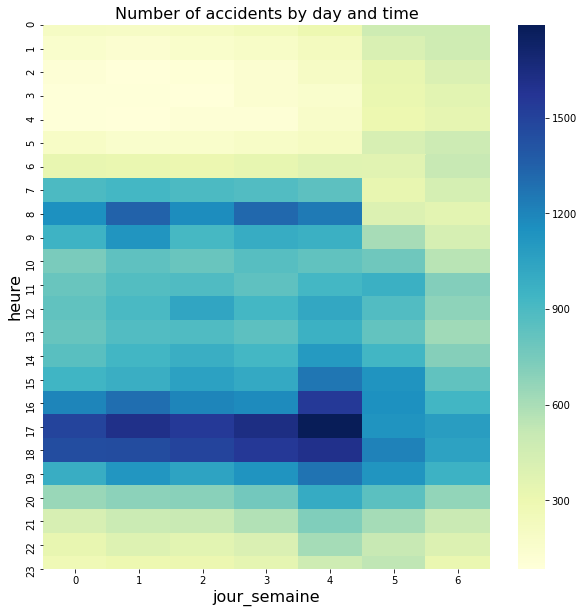

In [5]:
table = df_caracteristiques.pivot_table('Num_Acc', 'heure', 'jour_semaine', aggfunc="count")
plt.figure(figsize=(10, 10))
plt.title('Number of accidents by day and time', fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)

heatmap = sns.heatmap(table, cmap="YlGnBu")

Accidents most often occur on weekdays between 4 p.m. and 5 p.m. on Fridays.

## Cartographic representations

We're going to use the folium package to represent the accidents in the form of a map.

In [6]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

df_map = df_caracteristiques.dropna(subset=['lat','long'])
df_map = df_map[df_map.an=='2018']
df_map['count'] = 1

def generateBaseMap(default_location=[48.82, 2.34], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map


In [7]:
df_map_list = []

for heure in df_map.heure.sort_values().unique():
    df_map_list.append(df_map.loc[df_map.heure == heure, ['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist()) 
    
df_heure_list = df_map.heure.sort_values().unique().tolist()

base_map = generateBaseMap(default_zoom_start=11)

HeatMapWithTime(data=df_map_list, index = df_heure_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Limitation to Paris

We want to predict Parisian road accidents. We will first define the geographical limits of our study.

### The different districts of Paris

We'll limit ourselves to the administrative districts of Paris

In [8]:
data_quartier = pd.read_csv(f"{path}quartier_paris.csv", sep=";")
data_quartier.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000017,17,7510501,Saint-Victor,5,750000005,3087.215040,6.041561e+05,"48.8476636355,2.35409315338","{""type"": ""Polygon"", ""coordinates"": [[[2.354921..."
1,750000031,31,7510803,Madeleine,8,750000008,3791.509735,7.607266e+05,"48.871265493,2.32005302865","{""type"": ""Polygon"", ""coordinates"": [[[2.325031..."
2,750000078,78,7512002,Saint-Fargeau,20,750000020,5405.036433,1.486971e+06,"48.8710347391,2.40617153015","{""type"": ""Polygon"", ""coordinates"": [[[2.413813..."
3,750000063,63,7511603,Porte-Dauphine,16,750000016,7447.041546,3.086718e+06,"48.8717656343,2.27191774047","{""type"": ""Polygon"", ""coordinates"": [[[2.270984..."
4,750000069,69,7511801,Grandes-Carrières,18,750000018,6398.474434,1.905566e+06,"48.8925777711,2.33436308991","{""type"": ""Polygon"", ""coordinates"": [[[2.340216..."


In [9]:
import folium

paris_map = folium.Map(location=[48.83, 2.34], 
                       control_scale=True, 
                       zoom_start=12)

folium.Choropleth(geo_data=f"{path}quartier_paris.geojson", 
                     highlight=True, name='Quartier de Paris').add_to(paris_map)
paris_map

To determine accidents inside Paris, we use the function check_which_quartier

### Knowing whether to locate an accident

It is essential to be able to determine whether an accident has occurred in Paris and, secondly, the number of the administrative district of the latter.

In [10]:
import json
from shapely.geometry import shape, Point

def open_geojson_get_shapes(file):
    with open(file) as f:
        js=json.load(f)
    return js['features']

all_geo_shape = open_geojson_get_shapes(f"{path}quartier_paris.geojson")

def check_which_quartier(lon,lat,list_quartier=all_geo_shape, printing=False):
    point = Point(lat, lon)
    nb_quartier = None
    for quartier in list_quartier:
        polygon = shape(quartier['geometry'])
        if polygon.contains(point):
            nb_quartier = quartier["properties"]["c_qu"]
            if printing:
                print(f"Found in tiequar {quartier['properties']['l_qu']}")
    return nb_quartier
                  
    

In [11]:
l = check_which_quartier(48.83, 2.34, printing=True)
print(l)

Found in tiequar Parc-de-Montsouris
54


We apply this algorithm to our accident database. Searching the neighborhood of each accident is a little time-consuming when applied to the 118,000 accidents in our database. So we're going to do a rough pre-selection of Paris before we can determine more accurately

In [12]:
def check_within_ile_france(df_acc):
    mask = ((df_acc["lat"]<=48.95)& (df_acc["long"]<=2.55)
           & (48.7<=df_acc["lat"]) & (2.1<=df_acc["long"]))
    
    df_acc = df_acc[mask]
    return df_acc
    
df_caracteristiques = check_within_ile_france(df_caracteristiques)


In [13]:
df_caracteristiques.shape

(22525, 19)

In [14]:
from tqdm.auto import tqdm

tqdm.pandas(desc="my bar!")
df_caracteristiques['Num_Qu'] = df_caracteristiques.progress_apply(lambda x: check_which_quartier(x.lat, x.long), axis=1)
df_caracteristiques.head()
    

/Users/nbettache/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Date,jour_semaine,heure,Num_Qu
4666,201800004667,2018,06,30,0530,2,2,1,1.0,3.0,661,RD 59 - avenue de la ple,M,48.70165,2.25292,910,2018-06-30 05:30:00,5,5,NaN
5632,201800005633,2018,04,06,0015,5,2,1,1.0,5.0,88,QUINZIEME CORPS (AV. DU),M,48.86000,2.28000,60,2018-04-06 00:15:00,4,0,62.0
5669,201800005670,2018,05,20,1620,1,2,2,1.0,3.0,88,GARIGLIANO (PONTS),M,48.86272,2.28759,60,2018-05-20 16:20:00,6,16,64.0
10468,201800010469,2018,10,30,1300,1,1,1,2.0,7.0,620,D938,M,48.74097,2.11677,780,2018-10-30 13:00:00,1,13,NaN
19222,201800019223,2018,04,17,1200,1,2,1,1.0,1.0,635,Rue du 08 mai 1945,M,48.73498,2.20987,910,2018-04-17 12:00:00,1,12,NaN


In [15]:
df_paris_accident = df_caracteristiques[df_caracteristiques["Num_Qu"]>=0]

In [16]:
df_paris_accident.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Date,jour_semaine,heure,Num_Qu
5632,201800005633,2018,04,06,0015,5,2,1,1.0,5.0,88,QUINZIEME CORPS (AV. DU),M,48.86000,2.28000,60,2018-04-06 00:15:00,4,0,62.0
5669,201800005670,2018,05,20,1620,1,2,2,1.0,3.0,88,GARIGLIANO (PONTS),M,48.86272,2.28759,60,2018-05-20 16:20:00,6,16,64.0
20248,201800020249,2018,07,23,1531,1,2,3,7.0,6.0,33,RENAN (AVENUE ERNEST),M,48.86272,2.28759,180,2018-07-23 15:31:00,0,15,64.0
26701,201800026702,2018,11,22,1300,1,1,1,2.0,6.0,4,RD 2007,M,48.86272,2.28759,450,2018-11-22 13:00:00,3,13,64.0
28285,201800028286,2018,01,05,1755,5,1,2,3.0,6.0,395,DOMBASLE (PLACE),M,48.83550,2.30037,540,2018-01-05 17:55:00,4,17,57.0


In [17]:
df_paris_accident.shape

(10956, 20)

We end up with 11,000 accidents

# Add traffic sensors

We have 3000 traffic sensors that we are going to put on the map.

In [18]:
data_capteurs = pd.read_csv(f"{path}referentiel-comptages-routiers.csv",
                            sep=';')
data_capteurs.head()

,IU_AC,DATE_DEBUT,DATE_FIN,LIBELLE,IU_ND_AVAL,IU_ND_AMONT,LIBELLE_ND_AMONT,LIBELLE_ND_AVAL,geo_point_2d,geo_shape,SHAPE.LEN
0,5444,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Auteuil,2859,2465,SE_Auteuil,AE_A13,"48.8480073438,2.25343813301","{""type"": ""LineString"", ""coordinates"": [[2.2523...",0.0
1,5184,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Point_du_Jour,2504,2725,SE_VGP,AE_Lafont,"48.8354710712,2.2583742872","{""type"": ""LineString"", ""coordinates"": [[2.2569...",0.0
2,5446,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Parc_Princes,2489,2462,AE_Auteuil,SE_St_Cloud,"48.8430097717,2.25407136126","{""type"": ""LineString"", ""coordinates"": [[2.2548...",0.0
3,5169,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Pont_aval,604,2504,AE_Lafont,SE_Quai_Issy,"48.8348752621,2.26318604615","{""type"": ""LineString"", ""coordinates"": [[2.2598...",0.0
4,5214,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PI_Quai_Issy,598,595,SI_Quai_Issy,AI_Quai_Issy,"48.8352960423,2.26978165613","{""type"": ""LineString"", ""coordinates"": [[2.2719...",0.0


In [19]:
data_capteurs['geo_point_2d']=[i.split(',') for i in data_capteurs['geo_point_2d']]

In [20]:
capteurs_map = folium.Map(location=[48.83, 2.34], 
                       control_scale=True, 
                       zoom_start=12)

for index, row in data_capteurs.iloc[:200,:].iterrows():
    folium.Marker(row["geo_point_2d"], 
                  popup=row["LIBELLE"]).add_to(capteurs_map)
capteurs_map

We have only represented here $300$ traffic sensors in Paris, there are actually nearly $4000$. These $4000$ sensors send out traffic reports every hour. Over a year, that's $4000 \times 24 \times 365 \times 365 > 35 \times 10^6$ lines to be processed. So we decided to keep only $300$ sensors.


In [21]:
for index, row in data_capteurs.iterrows():
    lat, long = float(row["geo_point_2d"][0]),float(row["geo_point_2d"][1])
    data_capteurs.loc[index,"Num_Qu"]=check_which_quartier(lat, long)
    
data_capteurs.head()

,IU_AC,DATE_DEBUT,DATE_FIN,LIBELLE,IU_ND_AVAL,IU_ND_AMONT,LIBELLE_ND_AMONT,LIBELLE_ND_AVAL,geo_point_2d,geo_shape,SHAPE.LEN,Num_Qu
0,5444,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Auteuil,2859,2465,SE_Auteuil,AE_A13,"[48.8480073438, 2.25343813301]","{""type"": ""LineString"", ""coordinates"": [[2.2523...",0.0,61.0
1,5184,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Point_du_Jour,2504,2725,SE_VGP,AE_Lafont,"[48.8354710712, 2.2583742872]","{""type"": ""LineString"", ""coordinates"": [[2.2569...",0.0,61.0
2,5446,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Parc_Princes,2489,2462,AE_Auteuil,SE_St_Cloud,"[48.8430097717, 2.25407136126]","{""type"": ""LineString"", ""coordinates"": [[2.2548...",0.0,61.0
3,5169,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Pont_aval,604,2504,AE_Lafont,SE_Quai_Issy,"[48.8348752621, 2.26318604615]","{""type"": ""LineString"", ""coordinates"": [[2.2598...",0.0,61.0
4,5214,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PI_Quai_Issy,598,595,SI_Quai_Issy,AI_Quai_Issy,"[48.8352960423, 2.26978165613]","{""type"": ""LineString"", ""coordinates"": [[2.2719...",0.0,60.0


# Importing temperature data


Temperature data can also be used

In [22]:
df_temperature = pd.read_csv('./data/meteo_jour.csv')

In [23]:
df_temperature.head()

,jour,temp_high,temp_avg,temp_low,dew_point_high,dew_point_avg,dew_point_low,humidity_high,humidity_avg,humidity_low,speed_high,speed_avg,speed_low,pressure_high,pressure_low,precipitation_acc
0,1/01/2016,49.4,46.3,44.1,44.1,42.5,40.9,91.0,87.0,80.0,10.0,4.0,0.0,30.27,29.82,NaN
1,2/01/2016,52.6,49.6,46.7,46.3,44.3,40.9,89.0,82.0,74.0,11.0,6.1,3.0,29.82,29.74,NaN
2,3/01/2016,48.7,46.4,44.2,45.3,42.2,39.4,91.0,85.0,75.0,11.0,6.4,2.0,29.84,29.22,NaN
3,4/01/2016,51.9,47.4,44.9,44.3,42.1,40.5,86.0,82.0,73.0,8.0,4.9,2.0,29.30,29.23,NaN
4,5/01/2016,50.0,46.6,44.1,43.4,41.8,39.8,89.0,83.0,75.0,9.0,5.3,3.0,29.37,29.24,NaN


In [24]:
df_temperature["jour"] = pd.to_datetime(df_temperature["jour"],dayfirst=True).dt.date

This database gives us information on daily weather data between 2016 and 2018.

# Train dataset:

First we'll make a train base with the time and the block number. Our train base is constituted on the following index, we want to obtain for each hour for each district an estimate of the number of deaths. So we're going to create these two columns

In [25]:
from tqdm.auto import tqdm
tqdm.pandas(desc='Mybar')

In [26]:
import datetime
array_datetime = pd.date_range(datetime.datetime(year=2016, month=1, day=1, hour=1),
              datetime.datetime(year=2018, month=12, day=31, hour=23),
              freq="1h")


In [27]:
quartier = np.array(list(np.arange(1,81))*len(array_datetime))
hour = array_datetime.repeat(80)
df_train = pd.DataFrame({"Num_Qu":quartier, "Date":hour}, index = np.arange(len(array_datetime)*80))

In [28]:
df_train.shape

(2104240, 2)

In [29]:
df_paris_accident["Date"] = pd.to_datetime(df_paris_accident["Date"])

/Users/nbettache/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We've finished compiling our index, now we're going to tackle the data. 

## Number of accidents.

We're going to get the number of accidents for every hour and every neighborhood.

In [30]:
df_train["Num_Qu"] = df_train["Num_Qu"].astype(int)
df_train["Nb_Acc"] = 0
for index, row in tqdm(df_paris_accident.iterrows(), total=df_paris_accident.shape[0]):
    date_acc = row["Date"].replace(second=0, microsecond=0, minute=0)
    mask = (df_train["Date"]==date_acc) & (df_train["Num_Qu"]==row["Num_Qu"])
    df_train.loc[mask, ["Nb_Acc"]]+=1

In [31]:
len(df_train[df_train["Nb_Acc"]>0])

10866

# Import train and test data

All those steps are pretty long, that's why we can directly import the data using the function get_train_data from problem.py

In [32]:
from problem import get_train_data
data_train, target_train = get_train_data()

In [33]:
data_train.shape

(1472960, 9)

We do the same for test data

In [34]:
from problem import get_test_data
data_test, target_test = get_test_data()

In [35]:
data_test.shape

(631280, 9)

In [36]:
#df_train_acc is the base containing only the lines where there have been accidents
df_train_acc = df_train[df_train['Nb_Acc']>0].reset_index(drop=True)

In [37]:
#The column nb_previous_accident is replaced by the number of accidents that occurred in the previous hour for 
# a given neighborhood.

for i in tqdm(range(len(df_train_acc))):
    try:
        a = np.where((df_train['Date'] == df_train_acc.iloc[i]['Date'] + timedelta(hours=1)) &
                 (df_train['Num_Qu'] == df_train_acc.iloc[i]['Num_Qu']))
        df_train.loc[int(a[0]),'nb_previous_accident'] = df_train_acc.iloc[i]['Nb_Acc']
    except:
        pass


In [38]:
df_train.columns

Index(['Num_Qu', 'Date', 'Nb_Acc', 'nb_previous_accident'], dtype='object')

In [39]:
df_train_bis = df_train.groupby(['Date']).agg({'Nb_Acc' : 'sum', 
                                               'nb_previous_accident':'sum'}).reset_index()

In [40]:
df_train_bis['year'] = df_train_bis['Date'].apply(lambda x: x.year)
df_train_bis['month'] = df_train_bis['Date'].apply(lambda x: x.month)
df_train_bis['day'] = df_train_bis['Date'].apply(lambda x: x.day)
df_train_bis['day_of_week'] = df_train_bis['Date'].apply(lambda x: x.weekday())
df_train_bis['hour'] = df_train_bis['Date'].apply(lambda x: x.hour)

In [41]:
df_test_bis = df_train_bis[df_train_bis['year']==2018]
df_train_bis = df_train_bis[df_train_bis['year']<2018]

In [42]:
df_test_bis

,Date,Nb_Acc,nb_previous_accident,year,month,day,day_of_week,hour
17543,2018-01-01 00:00:00,0,0.0,2018,1,1,0,0
17544,2018-01-01 01:00:00,1,0.0,2018,1,1,0,1
17545,2018-01-01 02:00:00,0,1.0,2018,1,1,0,2
17546,2018-01-01 03:00:00,0,0.0,2018,1,1,0,3
17547,2018-01-01 04:00:00,0,0.0,2018,1,1,0,4
...,...,...,...,...,...,...,...,...
26298,2018-12-31 19:00:00,0,0.0,2018,12,31,0,19
26299,2018-12-31 20:00:00,0,0.0,2018,12,31,0,20
26300,2018-12-31 21:00:00,1,0.0,2018,12,31,0,21
26301,2018-12-31 22:00:00,0,1.0,2018,12,31,0,22


In [43]:
df_train_bis

,Date,Nb_Acc,nb_previous_accident,year,month,day,day_of_week,hour
0,2016-01-01 01:00:00,0,0.0,2016,1,1,4,1
1,2016-01-01 02:00:00,0,0.0,2016,1,1,4,2
2,2016-01-01 03:00:00,0,0.0,2016,1,1,4,3
3,2016-01-01 04:00:00,0,0.0,2016,1,1,4,4
4,2016-01-01 05:00:00,0,0.0,2016,1,1,4,5
...,...,...,...,...,...,...,...,...
17538,2017-12-31 19:00:00,1,0.0,2017,12,31,6,19
17539,2017-12-31 20:00:00,0,1.0,2017,12,31,6,20
17540,2017-12-31 21:00:00,0,0.0,2017,12,31,6,21
17541,2017-12-31 22:00:00,0,0.0,2017,12,31,6,22


## Some visualizations of time series

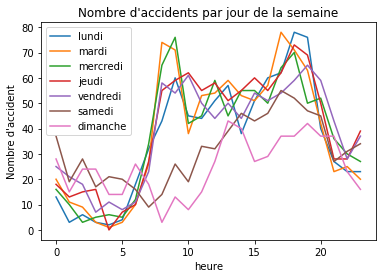

In [44]:
# Evolution of the number of accidents per hour for each day of the week

df_train_bis_2 = df_train_bis.groupby(['day_of_week','hour' ]).agg({'Nb_Acc':'sum'}).reset_index()
list_jours = df_train_bis_2['day_of_week'].unique()
jours = ['lundi', 'mardi', 'mercredi','jeudi', 'vendredi', 'samedi', 'dimanche']
for elt in list_jours:
    df_graph = df_train_bis_2[df_train_bis_2['day_of_week']==elt]
    plt.plot(df_graph['hour'], df_graph['Nb_Acc'], label=jours[elt])
    plt.xlabel('heure')
    plt.ylabel('Nombre d\'accident')
    plt.legend()
    plt.title('Nombre d\'accidents par jour de la semaine')

In [45]:
np.arange(2,13,2)

array([ 2,  4,  6,  8, 10, 12])

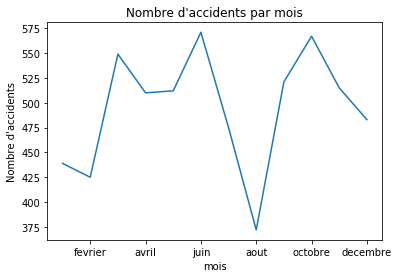

In [46]:
# Evolution of the number of accidents per month
df_train_bis_3 = df_train_bis.groupby(['month']).agg({'Nb_Acc':'sum'}).reset_index()
plt.plot(df_train_bis_3['month'], df_train_bis_3['Nb_Acc'] )
plt.xlabel('mois')
plt.ylabel('Nombre d\'accidents')
plt.title('Nombre d\'accidents par mois')
plt.xticks(np.arange(2,13,2), ['fevrier', 'avril', 'juin', 'aout', 'octobre', 'decembre'])
plt.show()

# Feature extractor

In [47]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        meteo_jour = pd.read_csv('./data/meteo_jour.csv')
        meteo_jour["jour"] = pd.to_datetime(meteo_jour["jour"], dayfirst=True).dt.date

        def process_date(X):
            date = pd.to_datetime(X['Date'])
            return np.c_[date.dt.year, date.dt.month, date.dt.day, date.dt.hour]
        date_transformer = FunctionTransformer(process_date, validate=False)



        temp_cols = ['temp_high', 'temp_avg', 'temp_low',
               'dew_point_high', 'dew_point_avg', 'dew_point_low', 'humidity_high',
               'humidity_avg', 'humidity_low', 'speed_high', 'speed_avg', 'speed_low',
               'pressure_high', 'pressure_low', 'precipitation_acc']

        def merge(X):
            X["jour"] = pd.to_datetime(X['Date']).dt.date
            df = pd.merge(X, meteo_jour, left_on='jour',
                          right_on='jour', how='left')

            return df[temp_cols]

        merge_transformer = FunctionTransformer(merge, validate=False)



        drop_cols = ["t_1h"]
        date_cols = ["Date"]
        merge_col = ["Date"]

        preprocessor = ColumnTransformer(
            transformers=[
                ('merge', make_pipeline(merge_transformer,
                                        SimpleImputer(strategy='median')), merge_col),
                ('date', make_pipeline(date_transformer,
                                       SimpleImputer(strategy='median')), date_cols),
                ('drop cols', 'drop', drop_cols),

            ])



        self.preprocessor = preprocessor
        self.preprocessor.fit(X_df, y_array)
        return self

    def transform(self, X_df):
        return self.preprocessor.transform(X_df)



## Baseline regressor

In [48]:
from sklearn import linear_model
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

class Regressor(BaseEstimator):
    def __init__(self):
        self.rgr = make_pipeline(StandardScaler(), linear_model.LinearRegression())  #Including scaling within the pipeline

    def fit(self, X, y):
        self.rgr.fit(X, y.reshape((len(y), 1)))

    def predict(self, X):
        y_pred = self.rgr.predict(X)
        return y_pred.reshape((len(y_pred), 1))

# Predictions

In [49]:
model = make_pipeline(FeatureExtractor(), Regressor())
model.fit(data_train, target_train)

Pipeline(memory=None,
         steps=[('featureextractor',
                 <__main__.FeatureExtractor object at 0x1a29efed10>),
                ('regressor', Regressor())],
         verbose=False)

In [50]:
from problem import get_test_data
data_test, target_test = get_test_data()

In [51]:
y_pred = model.predict(data_test)
y_pred.shape

(631280, 1)

# Model precision estimation

In [52]:
from problem import NRMSE

nrmse = NRMSE()
nrmse(target_test, y_pred)

array([0.12560428])

In [53]:
y_pred = y_pred.round().astype(int)

In [54]:
y_pred[y_pred>0]

array([], dtype=int64)

# Score metric

In [55]:
!ramp_test_submission --submission starting_kit

Testing Predicting number of accident
Reading train and test files from ./data ...
Reading cv ...
/Users/nbettache/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
Training submissions/starting_kit ...
CV fold 0
/Users/nbettache/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	score  nrmse  prec   rec      time
	train   0.11  0.02  1.00  8.351254
	valid   0.01  0.00  0.00  2.042935
	test    0.13  0.01  0.87  0.869767
CV fold 1
/Users/nbettache/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: 